In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
new_train_data = pd.read_csv('../datasets/Manatees/manatee_train_val_test_splits.csv')
old_train_data = pd.read_csv('../datasets/Manatees/Manatee_annotations_bg_from_calls.csv')

In [7]:
# remove 69 & 70
## - 20/80
## - 50/50
new_train_data.filename.unique()

array(['211127_0066', '211208_0069', '211208_0070', '211208_0072',
       '211208_0074', '211209_0077', '211210_0079', '211212_0081',
       '211212_0082', '211213_0083', '211213_0084', '211213_0086',
       '211220_0089', '211224_0090', '211227_0091', '211227_0093',
       '220104_0094', '220115_0097', '220118_0098', '220224_0102',
       '220224_0103', '220224_0104', '220225_0105', '220225_0106',
       '220225_0108', '220226_0109', '220226_0110', '220226_0111',
       '220227_0112', '220227_0113', '220227_0114', '220228_0117',
       '220228_0118', '211210_0078', '211212_0080'], dtype=object)

In [18]:
# remove outliers
new_train_data = new_train_data[~new_train_data.filename.isin(['211208_0069','211208_0070'])].reset_index(drop=True)

In [14]:
old_train_data.shape

(4095, 40)

In [15]:
new_train_data.shape

(3155, 23)

In [16]:
new_train_data[new_train_data.split_type=='train'].label.value_counts()

1    154
0     71
Name: label, dtype: int64

In [19]:
new_train_data.head()

,Selection,View,channel,begin_time,end_time,Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),...,PFC Min Freq (Hz),Max Freq (Hz),Annotation,filename,StartMicInWater,EndMicInWater,filepath,label,call_length,split_type
0,2,Spectrogram 1,1,13.317046,17.681407,3000.0,4350.0,0.1964,1350.0,-46.62,...,3375.0,3562.5,Y,211127_0066,13.213609,36.835417,annotations,0,4.364360,test
1,3,Spectrogram 1,1,17.877805,18.947378,3900.0,5475.0,0.2248,1575.0,-38.94,...,4125.0,5062.5,Y,211127_0066,13.213609,36.835417,annotations,0,1.069572,test
2,4,Spectrogram 1,1,19.172220,24.293471,2400.0,3900.0,0.1314,1500.0,-56.70,...,2625.0,3375.0,N,211127_0066,13.213609,36.835417,annotations,0,5.121251,test
3,5,Spectrogram 1,1,24.424855,26.460742,4500.0,6225.0,0.2262,1725.0,-48.95,...,4875.0,5437.5,Y,211127_0066,13.213609,36.835417,annotations,0,2.035887,test
4,6,Spectrogram 1,1,26.686939,32.289177,2625.0,3900.0,0.2790,1275.0,-59.71,...,2625.0,3750.0,N,211127_0066,13.213609,36.835417,annotations,0,5.602238,test


In [20]:
old_train_data.label.value_counts()

1    2066
0    2029
Name: label, dtype: int64

## train-test split by time

In [21]:
new_train_data.loc[:,'date_str'] = new_train_data.loc[:,'filename'].apply(lambda x: x[:6])

In [22]:
new_train_data.groupby('date_str').Selection.count().sort_index()

date_str
211127     15
211208    282
211209    123
211210    126
211212    105
211213     45
211220     23
211224     59
211227     12
220104    317
220115    177
220118     19
220224    421
220225    421
220226    459
220227    405
220228    146
Name: Selection, dtype: int64

In [23]:
new_train_data.groupby('date_str').call_length.sum().sort_index()

date_str
211127      23.621808
211208     871.416686
211209     593.582010
211210     306.202401
211212     675.489179
211213    1115.170052
211220     576.032270
211224     572.695769
211227      71.156854
220104     577.482456
220115     579.133588
220118     592.723790
220224    1404.912638
220225    1344.841476
220226    1583.409233
220227    1520.115254
220228    1350.622727
Name: call_length, dtype: float64

In [24]:
new_train_data.groupby('date_str').label.sum().sort_index()

date_str
211127      8
211208    142
211209     62
211210     64
211212     54
211213     24
211220     12
211224     30
211227      7
220104    159
220115     89
220118     10
220224    212
220225    212
220226    231
220227    204
220228     74
Name: label, dtype: int64

1. Test: last 3 days
2. Train-Val: 14 days
    1. sample by dates
    2. 20%-30%-40%-50%-60%-70%-80%

In [25]:
new_train_data.loc[:,'split_type'] = None

In [26]:
test_dates = ['220228','220227','220226']

In [27]:
sample_rate = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

In [28]:
new_train_data.loc[new_train_data['date_str'].isin(test_dates), 'split_type'] = 'test'

In [29]:
for sr in sample_rate:
    temp_sample_df = new_train_data.copy()
    train_instances = []
    for curr_date in set(temp_sample_df.date_str.unique())-set(test_dates):
        temp_df = temp_sample_df[temp_sample_df.date_str==curr_date]
        train_samples = list(temp_df.sample(frac=sr).index)
        train_instances += train_samples
    temp_sample_df.loc[temp_sample_df.index.isin(train_instances), 'split_type'] = 'train'
    temp_sample_df.loc[temp_sample_df.split_type.isna(), 'split_type'] = 'val'
    temp_sample_df = temp_sample_df[temp_sample_df.filename!='211210_0078'].reset_index(drop=True)
    print(temp_sample_df.split_type.value_counts())
    temp_sample_df.to_csv('../datasets/Manatees/manatee_update_sample_{}_each_day_no_outliers.csv'.format(sr), index=False)

val      1716
test     1010
train     428
Name: split_type, dtype: int64
val      1499
test     1010
train     645
Name: split_type, dtype: int64
val      1286
test     1010
train     858
Name: split_type, dtype: int64
train    1072
val      1072
test     1010
Name: split_type, dtype: int64
train    1287
test     1010
val       857
Name: split_type, dtype: int64
train    1499
test     1010
val       645
Name: split_type, dtype: int64
train    1716
test     1010
val       428
Name: split_type, dtype: int64


In [30]:
new_train_data.split_type.value_counts()

test    1010
Name: split_type, dtype: int64

## combine 2017 data

In [107]:
old_train_data = old_train_data.sample(500).reset_index(drop=True)

In [108]:
old_train_data.loc[:,'split_type'] = 'train'
old_train_data.loc[:,'filepath'] = 'annotations'
old_train_data.loc[:,'filename'] = old_train_data.loc[:,'filename'].apply(lambda x: '67407878.'+str(x))
old_train_data.loc[:,'channel'] = 1

In [109]:
old_train_data.channel.value_counts()

1    500
Name: channel, dtype: int64

In [110]:
new_train_data.channel.value_counts()

1    3175
Name: channel, dtype: int64

In [92]:
cols = list(set(old_train_data.columns)&set(new_train_data.columns))

In [93]:
concat_data = pd.concat([old_train_data[cols],new_train_data[cols]])

In [94]:
concat_data.head()

,label,Selection,Delta Time (s),begin_time,View,StartMicInWater,EndMicInWater,Low Freq (Hz),High Freq (Hz),filepath,call_length,end_time,Delta Freq (Hz),channel,filename,split_type
0,0,12,0.248,291.196,Spectrogram 1,24.659000,1710.758,872.6,2722.6,annotations,15.192,306.388,1850.0,1,67407878.170716112708,train
1,1,39,0.366,1725.235,Spectrogram 1,223.034000,1789.787,2691.4,80587.6,annotations,0.366,1725.601,77896.2,1,67407878.170716052709,train
2,0,38,0.372,1722.918,Spectrogram 1,223.034000,1789.787,1203.1,13456.8,annotations,0.926,1723.844,12253.7,1,67407878.170716052709,train
3,1,51,0.126,965.061,Spectrogram 1,2.817000,1437.053,1875.0,45221.1,annotations,0.126,965.187,43346.1,1,67407878.170713225715,train
4,0,276,0.488,4437.866,Spectrogram 1,71.428399,5391.007,1414.2,23714.3,annotations,3.574,4441.440,22300.1,1,67407878.170710005518,train


In [95]:
concat_data.shape

(3675, 16)

In [96]:
concat_data.label.value_counts()

1    1857
0    1818
Name: label, dtype: int64

In [97]:
concat_data.to_csv('../datasets/Manatees/manatee_concat_2017_sample_2022.csv', index=False)

In [72]:
old_train_data['call_length'].sum()

10420.021658417003

In [73]:
new_train_data['call_length'].sum()

14019.179500266999

3171.4


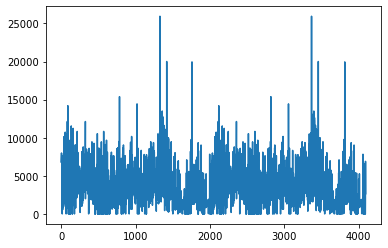

In [47]:
plt.plot(old_train_data['Low Freq (Hz)'])
print(old_train_data['Low Freq (Hz)'].median())

3384.615


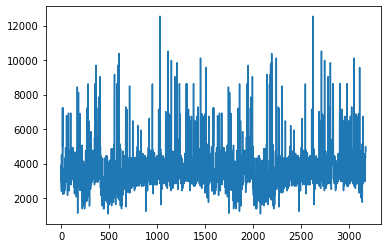

In [48]:
plt.plot(new_train_data['Low Freq (Hz)'])
print(new_train_data['Low Freq (Hz)'].median())

13169.7


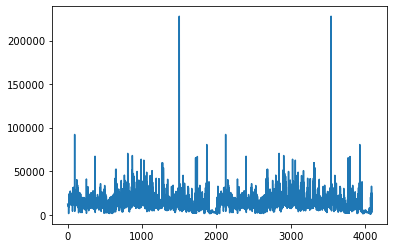

In [49]:
plt.plot(old_train_data['High Freq (Hz)'])
print(old_train_data['High Freq (Hz)'].median())

4314.607


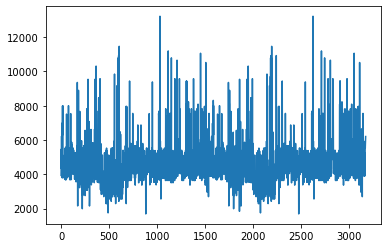

In [50]:
plt.plot(new_train_data['High Freq (Hz)'])
print(new_train_data['High Freq (Hz)'].median())